In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
if torch.cuda.is_available():
  device= torch.device("cuda:0")
  print("GPU")

else: 
  device = torch.device("cpu")
  print("CPU")

GPU


In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
mnist_test= datasets.MNIST(root='./data', train=False, download= False, transform=transforms.ToTensor())

In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset= mnist_train, batch_size = 100, shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset= mnist_test, batch_size = 100, shuffle= False)

In [ ]:
for (X_train,y_train) in train_loader:
  print("X_train:", X_train.size(), "type", X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break
for (X_test,y_test) in test_loader:
  print("X_test:", X_test.size(), "type", X_test.type())
  print('y_test:', y_test.size(), 'type:', y_test.type())
  break

X_train: torch.Size([100, 1, 28, 28]) type torch.FloatTensor
y_train: torch.Size([100]) type: torch.LongTensor
X_test: torch.Size([100, 1, 28, 28]) type torch.FloatTensor
y_test: torch.Size([100]) type: torch.LongTensor


In [ ]:
# 1 Color Channel, 6 filters (output channels), 3x3 kernel, stride = 1
conv1 = nn.Conv2d(1,6,3,1) # ---> 6 filters --> pooling --> conv2

# 6 input filters Conv1 , 6 filters, 3x3, stride = 1
conv2 = nn.Conv2d(6,16,3,1)

In [ ]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, X):
    X= F.relu(self.conv1(X))
    X= F.max_pool2d(X,2,2)
    X= F.relu(self.conv2(X))
    X= F.max_pool2d(X,2,2)
    X= X.view(-1,16*5*5)
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X= self.fc3(X)

    return F.log_softmax(X,dim=1)

In [ ]:
torch.manual_seed(42)

model= ConvolutionalNetwork().to(device)
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

# Variables(Trackers)
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []
# For loop epochs
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0
  total_loss= 0

  # Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b += 1
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(X_train).to(device) # Not flatten!
    loss = criterion(y_pred,y_train)
    total_loss += loss.cpu()

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr += batch_corr.cpu()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f"epoch: {i+1} Train Loss:{total_loss.item()/600} Train accuracy: {trn_corr.item()/60000}")

  train_losses.append(total_loss/600)
  train_correct.append(trn_corr)

  # Test
  total_loss= 0
  predictions= []
  true_labels= []
  with torch.no_grad():
    for step, (X_test,y_test) in enumerate(test_loader):
      step += 1

      X_test = X_test.to(device)
      y_test = y_test.to(device)

      y_val = model(X_test).to(device)

      predicted= torch.max(y_val.data,1)[1]
      tst_corr += (predicted==y_test).sum().cpu()

      predictions.append(predicted)
      true_labels.append(y_test)

      # Update test loss & accuracy for the epoch 
      loss = criterion(y_val, y_test)
      total_loss += loss.cpu()

      if step%100 == 0:
        print(f"epoch: {i+1} Test loss: {total_loss.item()/100} Test accuracy: {tst_corr.item()/10000}")

  test_losses.append(total_loss/100)
  test_correct.append(tst_corr)


current_time = time.time()
total= current_time-start_time
print(f"Training took {total/60} minutes")

epoch: 1 Train Loss:0.409610112508138 Train accuracy: 0.8765833333333334
epoch: 1 Test loss: 0.13031455993652344 Test accuracy: 0.9601
epoch: 2 Train Loss:0.11420682271321615 Train accuracy: 0.9645
epoch: 2 Test loss: 0.0714490270614624 Test accuracy: 0.977
epoch: 3 Train Loss:0.0789284070332845 Train accuracy: 0.97585
epoch: 3 Test loss: 0.06864306449890137 Test accuracy: 0.9772
epoch: 4 Train Loss:0.06106142044067383 Train accuracy: 0.9810666666666666
epoch: 4 Test loss: 0.057939281463623045 Test accuracy: 0.9796
epoch: 5 Train Loss:0.05124371528625488 Train accuracy: 0.9844666666666667
epoch: 5 Test loss: 0.04432775974273682 Test accuracy: 0.9847
epoch: 6 Train Loss:0.04337317784627279 Train accuracy: 0.9865333333333334
epoch: 6 Test loss: 0.041249141693115235 Test accuracy: 0.9858
epoch: 7 Train Loss:0.03823251088460287 Train accuracy: 0.9875833333333334
epoch: 7 Test loss: 0.04680344581604004 Test accuracy: 0.9841
epoch: 8 Train Loss:0.03243916193644206 Train accuracy: 0.989516666

In [ ]:
# Test accuracy
print(f"Test accuracy: {test_correct[-1].item()*100/10000}%")

Test accuracy: 98.56%


In [ ]:
train_losses

[tensor(0.4096, grad_fn=<DivBackward0>),
 tensor(0.1142, grad_fn=<DivBackward0>),
 tensor(0.0789, grad_fn=<DivBackward0>),
 tensor(0.0611, grad_fn=<DivBackward0>),
 tensor(0.0512, grad_fn=<DivBackward0>),
 tensor(0.0434, grad_fn=<DivBackward0>),
 tensor(0.0382, grad_fn=<DivBackward0>),
 tensor(0.0324, grad_fn=<DivBackward0>),
 tensor(0.0294, grad_fn=<DivBackward0>),
 tensor(0.0263, grad_fn=<DivBackward0>)]

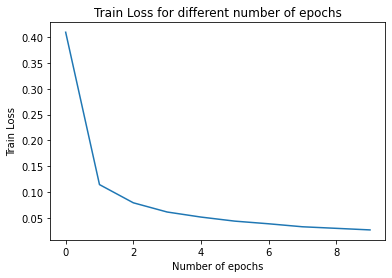

In [ ]:
with torch.no_grad():
  plt.plot(train_losses)
  plt.title("Train Loss for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Train Loss")


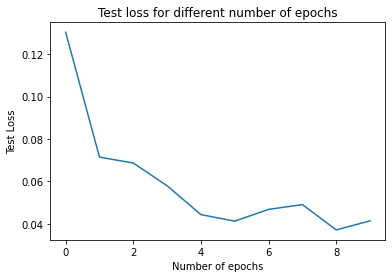

In [ ]:
with torch.no_grad():
  plt.plot(test_losses)
  plt.title("Test loss for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Test Loss")

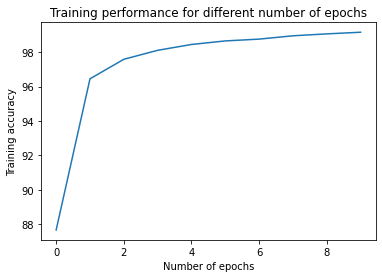

In [ ]:
with torch.no_grad():
  plt.plot([t/600 for t in train_correct])
  plt.title("Training performance for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Training accuracy")

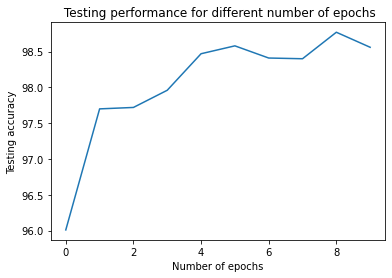

In [ ]:
with torch.no_grad():
  plt.plot([t/100 for t in test_correct])
  plt.title(" Testing performance for different number of epochs")
  plt.xlabel("Number of epochs")
  plt.ylabel("Testing accuracy")

In [ ]:
prediction_list= []
for i in predictions:
  for j in i:
    prediction_list.append(j.item())

In [ ]:
label_list= []
for i in true_labels:
  for j in i:
    label_list.append(j.item())

In [ ]:
print(confusion_matrix(label_list, prediction_list))
print("Precision score:", precision_score(label_list, prediction_list,  average="micro"))
print("Recall score:", recall_score(label_list, prediction_list, average="micro"))
print("F1_score:", f1_score(label_list, prediction_list,average="micro"))

[[ 967    0    1    1    0    4    2    1    3    1]
 [   0 1128    2    1    1    0    1    1    0    1]
 [   0    0 1012   11    1    1    0    6    1    0]
 [   0    0    1  999    0    8    0    0    2    0]
 [   0    0    2    0  971    0    1    1    1    6]
 [   1    0    0    7    0  880    1    1    1    1]
 [   6    2    2    0    2   11  933    0    2    0]
 [   0    2    2    4    0    0    0 1017    1    2]
 [   2    0    2    6    0    4    0    0  957    3]
 [   1    0    1    7    1    3    0    0    4  992]]
Precision score: 0.9856
Recall score: 0.9856
F1_score: 0.9856


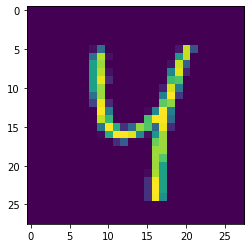

In [ ]:
plt.imshow(mnist_test[2022][0].reshape(28,28))

In [ ]:
model.eval()
with torch.no_grad():
  new_prediction = model(mnist_test[2022][0].view(1,1,28,28).to(device))

In [ ]:
new_prediction.argmax().cpu()

tensor(4)